In [18]:
# import dependencies
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import findspark
import numpy as np

from datetime import datetime, timedelta, date
### This program requires a local installation of APACHE SPARK to run

# Start Spark Session
findspark.init('C:\Spark\spark-3.2.2-bin-hadoop2.7')
import pyspark
from pyspark import SparkFiles
from pyspark.sql.functions import to_date, to_timestamp
from getpass import getpass


# Build Spark Session
### IMPORTANT: MAKE SURE THAT spark.config has memory set to 16GB or larger!
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Qwest-Analytics-Dashboard-and-ML-Model").config("spark.jars", "C:\Spark\spark-3.2.2-bin-hadoop2.7\jars\postgresql-42.5.0.jar").getOrCreate()

In [ ]:
# ### THIS IS THE FINAL DATABASE PULL, DO NOT RUN UNTIL OPTIMIZATIONS AND DATA CLEANING HAVE FINISHED ###

# # Connecting to database and exporting data

# #Store environmental variables
# password = getpass('Enter DataBase Password: ')

# #Configure for RDS
# mode = 'append'
# jdbc_url="jdbc:postgresql://qwest-final-project.ccngkdwtiuvz.us-east-2.rds.amazonaws.com:5432/Qwest-Database"
# config = {"user":"postgres", 
#           "password": password, 
#           "driver":"org.postgresql.Driver"}

# # Load the ProgrammaticData.csv which contains features and fill rate
# programmatic_data_df = spark.read.format("jdbc").options(
#          url='jdbc:postgresql://qwest-final-project.ccngkdwtiuvz.us-east-2.rds.amazonaws.com:5432/Qwest-Database',
#          dbtable='programmatic_data',
#          user='postgres',
#          password=password,
#          driver='org.postgresql.Driver').load()

# programmatic_data_df.show()
# programmatic_data_df.printSchema()

In [19]:
### PROVISONAL DATABASE ONLY.  DELETE IN FINAL VERSION.  FOR TESTING ONLY ###
programmatic_data = pd.read_csv('Resources/Clean_Advertising_Datav2.0.csv')
programmatic_data_df = pd.DataFrame(programmatic_data)

programmatic_data_df = programmatic_data_df.loc[programmatic_data_df['operator'] == 'Op_003']
programmatic_data_df
# This is a semi-cleaned dataset and is for one operator in the dataset

,date,country,region,operator,channel,pod_fill_rate,endpoint_requests,bid_requests,bid_responses,bid_wons,impressions,revenue,CPM,requested_pod_duration,requested_pod_droprate,filled_pod_duration,filled_pod_droprate,delivered_pod_duration
0,2022-02-28,United Kingdom,Europe,Op_003,Channel_003,0.03,14,1818,1102,132,5,0.11,22.0,122.0,-0.024016,119.07,-0.966406,4.00
1,2022-02-28,Spain,Europe,Op_003,Channel_003,0.02,82,11312,506,162,8,0.14,17.5,244.0,-0.671311,80.20,-0.950125,4.00
2,2022-02-28,France,Europe,Op_003,Channel_003,0.03,19,2621,132,33,2,0.02,10.0,122.0,-0.677705,39.32,-0.919634,3.16
3,2022-02-28,Italy,Europe,Op_003,Channel_003,0.02,14,1932,83,47,1,0.01,10.0,122.0,-0.297459,85.71,-0.975032,2.14
4,2022-02-28,Germany,Europe,Op_003,Channel_003,0.00,1,139,13,5,0,0.00,NaN,122.0,0.000000,122.00,-1.000000,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24773,2022-10-19,France,Europe,Op_003,Channel_002,0.14,9,1566,177,36,6,0.06,10.0,366.0,-0.235000,279.99,-0.821386,50.01
24774,2022-10-19,United Kingdom,Europe,Op_003,Channel_002,0.00,18,3402,1929,216,0,0.00,NaN,366.0,-0.016393,360.00,-1.000000,0.00
24775,2022-10-22,Germany,Europe,Op_003,Channel_002,0.04,12,2016,331,91,5,0.09,18.0,122.0,-0.039590,117.17,-0.955876,5.17
24776,2022-10-22,Switzerland,Europe,Op_003,Channel_002,0.00,9,1269,219,17,0,0.00,NaN,122.0,-0.653934,42.22,-1.000000,0.00


In [20]:
# In order to convert date to an integer or float, we need to determine how many days from some given day for the data we want to collect.

programmatic_data_df['date'] = pd.to_datetime(programmatic_data_df['date'])
programmatic_data_df = programmatic_data_df.sort_values(by='date', ascending=True)
programmatic_data_df

,date,country,region,operator,channel,pod_fill_rate,endpoint_requests,bid_requests,bid_responses,bid_wons,impressions,revenue,CPM,requested_pod_duration,requested_pod_droprate,filled_pod_duration,filled_pod_droprate,delivered_pod_duration
0,2022-02-28,United Kingdom,Europe,Op_003,Channel_003,0.03,14,1818,1102,132,5,0.11,22.000000,122.0,-0.024016,119.07,-0.966406,4.00
23503,2022-02-28,Spain,Europe,Op_003,Channel_002,0.00,15,2062,116,39,0,0.00,NaN,122.0,-0.556803,54.07,-1.000000,0.00
23504,2022-02-28,Switzerland,Europe,Op_003,Channel_002,0.00,2,242,13,2,0,0.00,NaN,122.0,-0.836066,20.00,-1.000000,0.00
23505,2022-02-28,France,Europe,Op_003,Channel_002,0.00,2,275,8,1,0,0.00,NaN,122.0,-0.877049,15.00,-1.000000,0.00
23506,2022-02-28,Italy,Europe,Op_003,Channel_002,0.00,6,828,0,0,0,0.00,NaN,244.0,-1.000000,0.00,NaN,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11522,2022-10-25,Switzerland,Europe,Op_003,Channel_001,0.00,5,745,61,1,0,0.00,NaN,122.0,-0.967213,4.00,-1.000000,0.00
11518,2022-10-25,Italy,Europe,Op_003,Channel_001,0.31,6,1290,279,33,9,0.12,13.333333,366.0,-0.016393,360.00,-0.687500,112.50
11517,2022-10-25,United Kingdom,Europe,Op_003,Channel_001,0.06,24,4743,2667,240,12,0.24,20.000000,366.0,-0.020492,358.50,-0.937238,22.50
11520,2022-10-25,Spain,Europe,Op_003,Channel_001,0.01,43,7464,373,40,1,0.02,20.000000,122.0,-0.797951,24.65,-0.971602,0.70


In [21]:
# isolate the needed columns and do datetime to int conversion
ml_df = programmatic_data_df[['date', 'revenue']]
ml_df['date_from'] = (ml_df['date'] - pd.to_datetime('2022-01-01'))
# convert to integer
ml_df['date_from'] = (ml_df['date_from'] / np.timedelta64(1, 'D')).astype(int)

C:\Users\Peter Nguyen\AppData\Local\Temp\ipykernel_22244\1969868375.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ml_df['date_from'] = (ml_df['date'] - pd.to_datetime('2022-01-01'))
C:\Users\Peter Nguyen\AppData\Local\Temp\ipykernel_22244\1969868375.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ml_df['date_from'] = (ml_df['date_from'] / np.timedelta64(1, 'D')).astype(int)


In [23]:
ml_df = ml_df.groupby('date').sum()
ml_df

,revenue,date_from
date,,
2022-02-28,0.47,928
2022-03-01,1.31,885
2022-03-02,0.77,960
2022-03-03,1.31,915
2022-03-04,1.46,930
...,...,...
2022-10-21,2.03,2344
2022-10-22,1.68,3234
2022-10-23,1.07,1770


In [ ]:
### ADDITIONAL DATA CLEANING AND PROCESSING?

# modify date?
# Country?
# how can the bid features be used?  Does this require neural network?
# for now build revenue prediction linear regression, but later lets see if we can provide more insight.

# need to separate into operators.  Dependant variable date, and independent variable revenue.


In [24]:
#reformat data to accept scikit library, x data is now in ([[value], [value]...[value]]) format
x=ml_df.date_from.values.reshape(-1,1)
x.shape

y=ml_df.revenue

In [25]:
#instantiate variable model with LinearRegression function, and fit x,y values.  .predict() function will accept x where x equals a number ([[#]])
model = LinearRegression()
model.fit(x,y)
y_pred = model.predict(x)
# prints number of points in prediction model
print(y_pred.shape)

(235,)


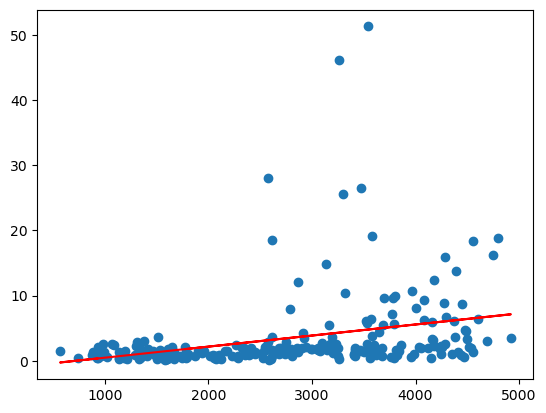

In [26]:
# plot the linear regression on the scatter plot
plt.scatter(x,y)
plt.plot(x, y_pred, color="red")
plt.show()

In [27]:
# get values of linear regression formula
print(model.coef_)
print(model.intercept_)

### THIS PROVISIONAL ML MODEL IS A BASIC linear regression model.  Further EDA might reveal higher order variables that can utilize non-linear functions that may predict price better.
### EDA for this dataset is still in progress.  Potentially a neural network model may be required.

[0.00169892]
-1.2270028602626688
